# PROGETTO FINALE DEL CORSO MACHINE LEARNING: TECNICHE AVANZATE 

Il progetto consiste nello sviluppo di un modello di machine learning per la face detection. Il modello deve essere in grado di rilevare la presenza di un volto all'interno di una foto e di tracciare dei boundaring box intorno ad essi. 

La strategia scelta per svolgere il progetto è quella di addestrare inizalmente il modello in grado di classificare correttamente le foto che rappresentano volti da quelle che rappresentano oggetti (o non volti).
Il modello scelto è un SVM e le features delle immagini saranno HOG features (Histogram of Oriented Gradients) . Successivamente verrà utilizzata la tecnica dello sliding window che consiste nel "far scorrere" una finestra rettangolare su tutta l'immagine in esame, analizzando ciascuna posizione della finestra per determinare se contiene o meno l'oggetto di interesse, nel caso specifico, un volto.


Per il progetto sono stati scaricati due dataset da GitHub e  Kaggle:
* Olivetti face per le foto di volti (classe positiva)
   Il dataset è stato scaricato dalla pagina Github `https://github.com/lloydmeta/Olivetti-PNG`
   Questo dataset contiente foto di volti di 40 persone, in diverse angolazioni. Le foto sono 400, in formato PNG e dimensioni 64x64 

* nonface and face dataset  `https://www.kaggle.com/datasets/sagarkarar/nonface-and-face-dataset`
Il dataset contiene più di 2900 immagini, di cui 1331 rappresentano volti umani. Sono state utilizzate solo le immagini che non rappresentano volti umani per creare gli esempi della classe negativa.
Inizialmente avevo utilizzato solo questo dataset, prendendo sia la classe positiva che negativa. Poicché le foto dei volti hanno molto sfondo, il modello "imparava" che anche gli sfondi erano volti



In [331]:
# Importiamo le librerie che ci servono

import os 
import random 
import glob
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report,confusion_matrix
from skimage import exposure
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  FunctionTransformer

In [281]:
## Estraiamo i path delle foto della classe positiva

positive_images=[os.path.join("Olivetti-PNG/images/",face) for face in os.listdir("Olivetti-PNG/images/")if face.endswith("png")]



In [282]:
## Definiamo una funzione che seleziona n  immagini per la classe negativa
# La funzione restituisce una lista con i paths delle immagini 
def extract_random_negative(dataset,num):
    # Settiamo il seed per rendere riproducibile la scelta delle immagini
    random.seed(30)
    negative_images=[os.path.join(dataset,image) for image in os.listdir(dataset) if not image.startswith("Human")]

    
    selected_negative_images= random.sample(negative_images,num)
  
    return selected_negative_images

In [283]:
# Definiamo una funzione per riformattare le immagini 
def resize_image(image, target_size=(64,64)):
    return cv2.resize(image, target_size)

In [284]:
# Estraiamo un numero uguale di foto dalla classe nagativa non-volti
negative_images=extract_random_negative("Dataset",400)

Ora che abbiamo i nostri due dataset, possiamo procedere al caricamento delle immagini e l'estrazione delle HOG features. 
Iniziamo con le immagini dei volti (classe positiva)

In [285]:
features_positive=[]
labels_positive=[]

for png in positive_images:
  
    image = cv2.imread(png)
    
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized=resize_image(gray_image)
    hog_features, hog_image = hog(resized, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
    hog_feature_eq = exposure.equalize_hist(hog_features)
    features_positive.append(hog_feature_eq)
    labels_positive.append(1)
features_pos = np.asarray(features_positive)
labels_pos=np.asarray(labels_positive)

In [286]:
features_pos[2].shape

(15876,)

Ora passiamo alle features negative 



In [287]:
features_negative=[]
labels_negative=[]

for png in negative_images:
    # Carica un'immagine
    image = cv2.imread(png)
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized=resize_image(gray_image)
    hog_features, hog_image = hog(resized, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
    hog_feature_eq = exposure.equalize_hist(hog_features)
    features_negative.append(hog_feature_eq)
    labels_negative.append(0)
features_neg = np.asarray(features_negative)
labels_neg=np.asarray(labels_negative)

In [288]:
# Uniamo gli array per creare il nostro dataset totale
features_total=np.concatenate((features_pos,features_neg),axis=0)
labels_total=np.concatenate((labels_pos,labels_neg),axis=0)

Dividiamo il dataset in train e test e iniziamo ad addestrare il modello SVM

In [289]:
X_train, X_test, y_train, y_test = train_test_split(features_total, labels_total, test_size=0.2, random_state=42)

In [290]:

clf = LinearSVC()
clf.fit(X_train, y_train)

/Users/lorenzodemarco/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1)

In [291]:
y_pred=clf.predict(X_test)


In [292]:
print(classification_report(y_true=y_test,y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



In [293]:
confusion_matrix(y_test,y_pred)

array([[80,  0],
       [ 0, 80]])

In [294]:
# proviamo con una nuova immagine

path="/Users/lorenzodemarco/Desktop/MasterProfessionAI/MLavanzato/tiny-imagenet-200/train/n01629819/images/n01629819_3.JPEG"
image = cv2.imread(path)
# Converti l'immagine in scala di grigi
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Calcola le HOG features
hog_features, hog_image = hog(gray_image, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
hog_feature_eq = exposure.equalize_hist(hog_features)


clf.predict([hog_feature_eq])


array([0])

[1]


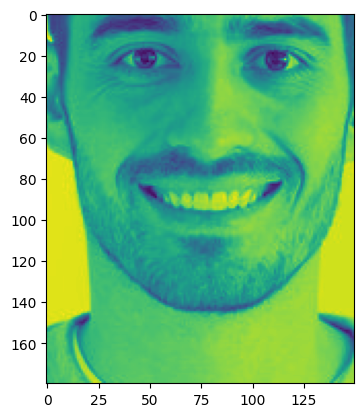

In [295]:
path="prova.jpeg"
image = cv2.imread(path)

# Converti l'immagine in scala di grigi
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Estraggo la faccia "manualmente"
resized_gray_image=resize_image(gray_image[120:300,200:350])

plt.imshow(gray_image[120:300,200:350])

# Calcola le HOG features
hog_features, hog_image = hog(resized_gray_image, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
hog_feature_eq = exposure.equalize_hist(hog_features)


print(clf.predict([hog_features]))

#plt.imshow(resized_gray_image)


[1]


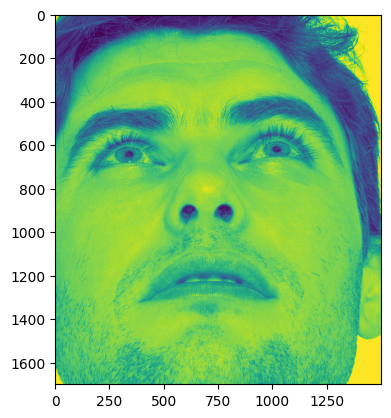

In [296]:
path="portrait-young-man-looking-up-isolated-white.jpg"
image = cv2.imread(path)

# Converti l'immagine in scala di grigi
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Estraggo la faccia "manualmente"
resized_gray_image=resize_image(gray_image[1500:3200,2000:3500])

plt.imshow(gray_image[1500:3200,2000:3500])

# Calcola le HOG features
hog_features, hog_image = hog(resized_gray_image, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
hog_feature_eq = exposure.equalize_hist(hog_features)


print(clf.predict([hog_features]))

Ora che abbiamo ottenuto il modello procediamo a tracciare i bounding box nel caso di nuove foto.
Utilizziamo un approccio sliding window che consiste nel far scorrere una "finestra" sulla nostra immagine e effettuare su ogni finestra una predizione

In [310]:
def sliding_window(image, step_size, window_size):
   
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_faces(image, model, window_size=(128,128), step_size=8):
    
    detected_faces = []
    bounding_boxes = []
    image = cv2.imread(image)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for (x, y, window) in sliding_window(image, step_size=step_size, window_size=window_size):
       
        
        resized_wind=resize_image(window)
        hog_features = hog(resized_wind,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
        hog_features=exposure.equalize_hist(hog_features)    
        prediction = model.predict([hog_features])
        
        if prediction == 1:
            bounding_boxes.append((x, y, x + window_size[0], y + window_size[1]))
    
    bounding_boxes = np.array(bounding_boxes)
    
    
    return bounding_boxes

boxes = detect_faces("prova.jpeg", clf)

In [311]:
boxes

array([[208,  96, 336, 224],
       [216,  96, 344, 224],
       [224,  96, 352, 224],
       [208, 104, 336, 232],
       [216, 104, 344, 232],
       [224, 104, 352, 232],
       [208, 112, 336, 240],
       [216, 112, 344, 240],
       [224, 112, 352, 240],
       [208, 120, 336, 248],
       [216, 120, 344, 248],
       [224, 120, 352, 248]])

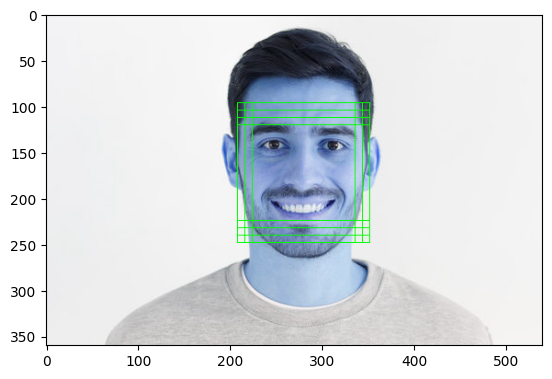

In [312]:
def draw_boxes(image, boxes, color=(0, 255, 0), thickness=1):
    # Disegna i bounding boxes sull'immagine
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    return image

# Carica l'immagine
input_image = cv2.imread('prova.jpeg')
image_with_boxes = draw_boxes(input_image.copy(), boxes)

# Visualizza l'immagine con i bounding boxes
plt.imshow( image_with_boxes)


In [329]:
def overlapping_area(detection_1, detection_2):
    '''
    Da ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[2]
    x2_br = detection_2[0] + detection_2[2]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[3]
    y2_br = detection_2[1] + detection_2[3]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[2] * detection_2[3]
    area_2 = detection_2[2] * detection_2[3]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=.5):

    if len(detections) == 0:
	    return []
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)

    new_detections=[]
    new_detections.append(detections[0])

    del detections[0]
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections

Il modello sembra funzionare abbastanza bene. Abbiamo però alcune cose da sistemare. 
Per prima cosa, ci sono molti bounding boxes che si sovrappongono. Questo può essere eliminato con l'algoritmo Non-Maximum Suppression (NMS) che mantiene solo i bounding boxes con una probabilità elevata e con una distanza sufficiente dagli altri bounding boxes.  Aggiungiamo quindi uno score di confidenza, in modo da ridurre già di per sé le boxes.


In [313]:
def sliding_window(image, step_size, window_size):
   
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_faces2(image, model, window_size=(128,128), step_size=8):
    
    bounding_boxes = []

   
    image = cv2.imread(image)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    for (x, y, window) in sliding_window(image, step_size=step_size, window_size=window_size):
       
        
        resized_wind=resize_image(window)
        hog_features = hog(resized_wind,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
        hog_features=exposure.equalize_hist(hog_features)    
        

        prediction = model.predict([hog_features])
        confidence_score = clf.decision_function([hog_features])[0]
    
        if prediction == 1 :
            
            bounding_boxes.append((x, y, x + window_size[0], y + window_size[1],confidence_score))
        
    bounding_boxes = np.array(bounding_boxes)
    
    
    return bounding_boxes


boxes = detect_faces2("prova.jpeg", clf)

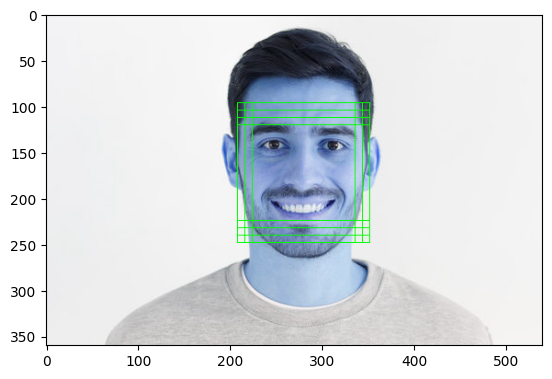

In [314]:
def draw_boxes2(image, boxes, color=(0, 255, 0), thickness=1):
    # Disegna i bounding boxes sull'immagine
    for (x1, y1, x2, y2,conf) in boxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    return image

image_with_boxes = draw_boxes2(input_image.copy(), boxes)

# Visualizza l'immagine con i bounding boxes
plt.imshow( image_with_boxes)


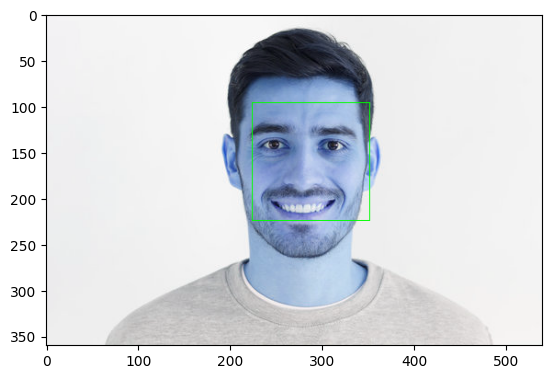

In [330]:
[score[4] for score in boxes]


new=nms(boxes,  threshold=0.1)

image_with_boxes = draw_boxes2(input_image.copy(), new)

# Visualizza l'immagine con i bounding boxes
plt.imshow( image_with_boxes)

Il risultato è decisamente migliorato. 


## Pipeline
Ora che è tutto pronto, trasformiamo i nostri step in una Pipeline

In [335]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized=resize_image(gray_image)
    hog_features, hog_image = hog(resized, visualize=True,orientations=9, pixels_per_cell=(4,4), cells_per_block= (3,3))
    hog_feature_eq = exposure.equalize_hist(hog_features)
    return hog_feature_eq
    

In [342]:
pipeline = Pipeline([
    ('preprocessing', preprocess_image),
    ('svm_model', LinearSVC()),
    ('face_detector',detect_faces2),
    ('visualize',draw_boxes2)
])